# Fraud Detection Machine Learning Model

### Built with Ensemble learning, Hyperparameter Optimization and Explainable AI(XAI) 

# Ensemble Learning and Hyperparameter Optimization

- ### Using Logistic Regression, Random forest and XGBClassifier (Extreme Gradient Boosting)
- ### Optimized with different hyperparameters to improve performance through fine-tuning.
- ### We are focused on ***Precision*** and ***F1- Score*** rather than just accuracy since we are dealing with a Fraud detection model.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

# To suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("processed_data/Fraud(preprocessed).csv")
data

,type,amount,newbalanceOrig,newbalanceDest,isFraud
0,DEBIT,5337.77,36382.23,40348.79,0
1,DEBIT,9644.94,0.00,157982.12,0
2,CASH_OUT,229133.94,0.00,51513.44,0
3,DEBIT,9302.79,1996.21,16896.70,0
4,TRANSFER,311685.89,0.00,2719172.89,0
...,...,...,...,...,...
3923181,CASH_OUT,63416.99,0.00,339850.17,1
3923182,CASH_OUT,1258818.82,0.00,1762283.33,1
3923183,CASH_OUT,339682.13,0.00,339682.13,1
3923184,CASH_OUT,6311409.28,0.00,6379898.11,1


In [3]:
data['isFraud'].value_counts()

isFraud
0    3919064
1       4122
Name: count, dtype: int64

## The data is unbalanced
### N/B: An unbalanced dataset affects precision and accuracy score in evaluation metrics

## Handling Class Imbalances

In [4]:
# Seperating the data in the 'isFraud' column ( 0 & 1)
notFraud = data[data['isFraud'] == 0]
fraud = data[data['isFraud'] == 1]

# To balance the data
notFraud = notFraud.sample(fraud.shape[0])

# Joining the dataset; notFraud and fraud together into the final dataframe for prediction
balanced_data = pd.concat([notFraud, fraud], axis=0)

In [5]:
data = balanced_data.copy()

## Transform the categorical data to numerical data

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
label_encoder = LabelEncoder()

for col in data.select_dtypes(include = ['object', 'category']).columns:
    data[col] = label_encoder.fit_transform(data[col])

In [8]:
# Separate features (X) and target variable (y)
X = data.drop('isFraud', axis=1)
y = data['isFraud']

In [9]:
data.dtypes

type                int32
amount            float64
newbalanceOrig    float64
newbalanceDest    float64
isFraud             int64
dtype: object

## Splitting the data into **training data** and **validation data**

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

In [11]:
from sklearn.preprocessing import StandardScaler

#Applying feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### I will establish **Hyperparameters** for the computer to systematically search the best hyperparameters for a given machine learning model.

In [13]:
from sklearn.model_selection import GridSearchCV

# Different models for classification so we get the best result
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import  classification_report

## Using Logistic Regression

In [14]:
logic = LogisticRegression(solver='lbfgs', max_iter=500)

# Hyperparameter grid
hyperparameters = {
    'penalty': ['l2'],
    'C': [1, 10, 100]
}

# GridSearchCV
lr_classifier = GridSearchCV(
    estimator=logic,
    param_grid=hyperparameters,
    cv=5,
    scoring='accuracy'
)

lr_classifier.fit(X_train, y_train)

y_pred = lr_classifier.predict(X_test)

# Best hyperparameters
print("Best Hyperparameters:", lr_classifier.best_params_)
# Best model
print("Best Estimator:", lr_classifier.best_estimator_)
# Classification report (focus on precision and f1-score)
print(classification_report(y_pred, y_test))

Best Hyperparameters: {'C': 100, 'penalty': 'l2'}
Best Estimator: LogisticRegression(C=100, max_iter=500)
              precision    recall  f1-score   support

           0       0.60      0.83      0.69       606
           1       0.87      0.68      0.76      1043

    accuracy                           0.73      1649
   macro avg       0.73      0.75      0.73      1649
weighted avg       0.77      0.73      0.74      1649



## Using Random Forest

In [15]:
# Random Forest model
rfc = RandomForestClassifier(criterion='entropy')

# Hyperparameter grid
hyperparameters = {
    'n_estimators': [100, 200, 300, 500],
}

# GridSearchCV
rf_classifier = GridSearchCV(
    estimator=rfc,
    param_grid=hyperparameters,
    cv=5,
    scoring='accuracy'
)

# Train
rf_classifier.fit(X_train, y_train)

# Predict
y_pred_2 = rf_classifier.predict(X_test)

# Best hyperparameters
print("Best Hyperparameters:", rf_classifier.best_params_)
# Best model
print("Best Estimator:", rf_classifier.best_estimator_)
# Classification report (focus on precision and f1-score)
print(classification_report(y_pred_2, y_test))

Best Hyperparameters: {'n_estimators': 100}
Best Estimator: RandomForestClassifier(criterion='entropy')
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       865
           1       0.75      0.78      0.77       784

    accuracy                           0.78      1649
   macro avg       0.77      0.78      0.77      1649
weighted avg       0.78      0.78      0.78      1649



## Using XGB Classifier

In [16]:
# XGB Classifier Model
xgb = XGBClassifier(
    use_label_encoder=False,   # Suppress warning about label encoder
    eval_metric='logloss'      # Suppress warning about eval_metric
)

# Hyperparameter grid
hyperparameters = {
    'max_depth': [3, 6, 10],              # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1],   # Step size shrinkage 
    'n_estimators': [100, 500, 1000],     # Number of boosting rounds
}

# GridSearchCV
xgb_classifier = GridSearchCV(
    estimator=xgb,
    param_grid=hyperparameters,
    cv=5,
    scoring='average_precision',
    verbose=1,
    n_jobs=-1
)

# Train
xgb_classifier.fit(X_train, y_train)

# Predict
y_pred_3 = xgb_classifier.predict(X_test)

# Best hyperparameters
print("Best Hyperparameters:", xgb_classifier.best_params_)
# Best model
print("Best Estimator:", xgb_classifier.best_estimator_)
# Classification report (focus on precision and f1-score)
print(classification_report(y_test, y_pred_3))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
              precision    recall  f1-score   support

           0       0.82  

- ### Based on the three models and various hyperparameters, from the classification report, we can see that the "**XGBClassifier**" is the best model.
- ### XGBClassifier performs the best when it comes to ***Precision*** and ***F1-Score***.

## Visual Model Result

### Confusion Matrix

Confusion Matrix for XGBoost Classifier


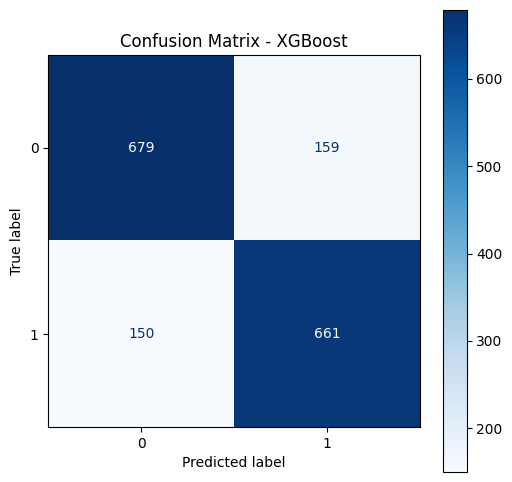

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Create and plot the confusion matrix
print("Confusion Matrix for XGBoost Classifier")
cm = confusion_matrix(y_test, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')  # 'd' formats numbers as integers
plt.title('Confusion Matrix - XGBoost')
plt.grid(False) 
plt.show()

### Precision-Recall Curve

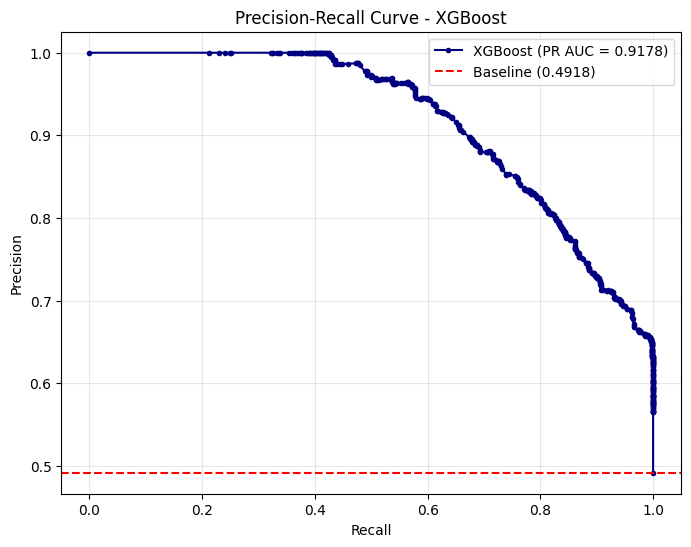

Baseline (naive classifier): 0.4918
Area Under PR Curve (PR AUC): 0.9178


In [18]:
y_scores = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve points
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate the Area Under the Precision-Recall Curve (PR AUC)
pr_auc = auc(recall, precision)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'XGBoost (PR AUC = {pr_auc:.4f})', color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# The baseline is the proportion of positive cases in the test set
baseline = len(y_test[y_test==1]) / len(y_test)
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline ({baseline:.4f})')
plt.legend()

plt.show()

# Print a helpful interpretation
print(f"Baseline (naive classifier): {baseline:.4f}")
print(f"Area Under PR Curve (PR AUC): {pr_auc:.4f}")

- A model with no skill would be a horizontal line at y = baseline.
- The closer the curve is to the top-right corner, the better the model.
- A higher PR AUC (closer to 1.0) indicates better performance.

### Save the models and dataset

In [19]:
# Save to CSV
data.to_csv("Fraud_final.csv", index=False)  # index=False prevents pandas from writing row numbers

import pickle

# Save the best model (xgb classifier)
with open("best_model.pkl", "wb") as f:
    pickle.dump(xgb_classifier.best_estimator_, f)

# Save the Scaler (SStandardScaler)
with open("f_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)